In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from tqdm import tqdm
import logging
from PIL import Image

In [2]:
logging.basicConfig(
    format="%(asctime)s %(levelname)-8s %(message)s",
    level=logging.INFO,
    datefmt="%Y-%m-%d %H:%M:%S",
)

In [3]:
import importlib
import euler_utils
importlib.reload(euler_utils)

<module 'euler_utils' from '/cluster/home/mfrancesc/IVT/eqasim-java/switzerland/WaitTimeValidation/euler_utils.py'>

In [4]:
last_iter = 100

In [5]:
main_folder = '/cluster/work/ivt_vpl/mfrancesc/SA_scenario/'

In [6]:
no_rej_4000 = euler_utils.read_output(main_folder + 'no_rejections_4000', last_iter)
euler_utils.compute_delay_factor_from_estimated(no_rej_4000['drt_trips_stats'])

  0%|          | 0/101 [00:00<?, ?it/s]2023-01-16 18:33:03 INFO     Note: detected 128 virtual cores but NumExpr set to maximum of 64, check "NUMEXPR_MAX_THREADS" environment variable.
2023-01-16 18:33:03 INFO     Note: NumExpr detected 128 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
100%|██████████| 101/101 [00:00<00:00, 570.87it/s]


In [7]:
no_rej_6000 = euler_utils.read_output(main_folder + 'no_rejections_6000', last_iter)
euler_utils.compute_delay_factor_from_estimated(no_rej_6000['drt_trips_stats'])

100%|██████████| 101/101 [00:00<00:00, 638.19it/s]


In [8]:
rej_4000 = euler_utils.read_output(main_folder + 'rejections_4000', last_iter)
euler_utils.compute_delay_factor_from_estimated(rej_4000['drt_trips_stats'])

100%|██████████| 101/101 [00:00<00:00, 686.54it/s]


In [9]:
rej_6000 = euler_utils.read_output(main_folder + 'rejections_6000', last_iter)
euler_utils.compute_delay_factor_from_estimated(rej_6000['drt_trips_stats'])

100%|██████████| 101/101 [00:00<00:00, 609.81it/s]


# Occupancy profiles

In [10]:
occupancy_profile_path = '/ITERS/it.' + str(last_iter) + '/' + str(last_iter) + '.occupancy_time_profiles_Line_drt.png'
folders = ['no_rejections_4000', 'no_rejections_6000', 'rejections_4000', 'rejections_6000']
occupancy_profile_paths = [main_folder + f + occupancy_profile_path for f in folders]


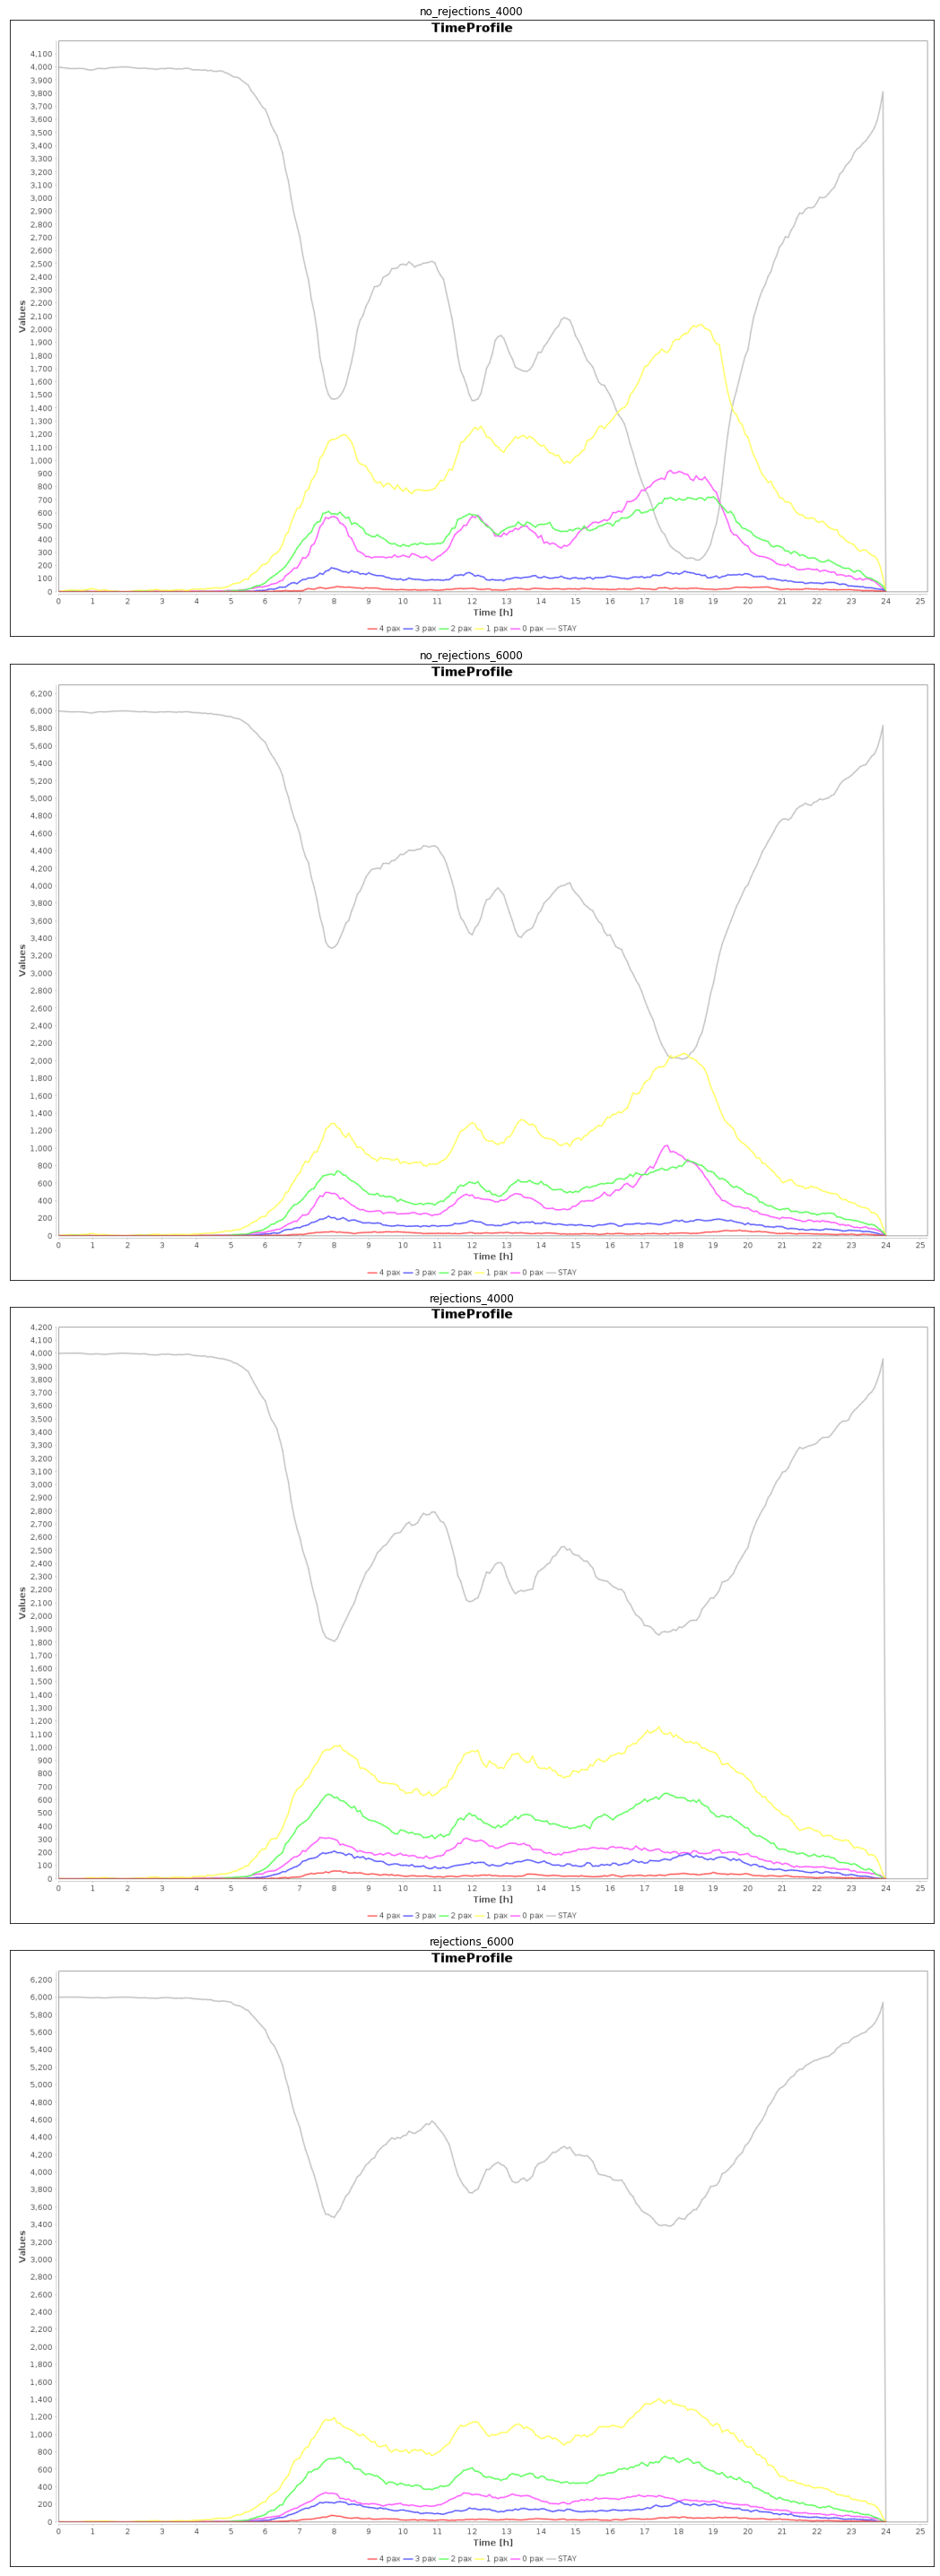

In [11]:
plt.figure(figsize=(25,40))
for i in range(1,5):
    plt.subplot(4,1,i)
    plt.imshow(Image.open(occupancy_profile_paths[i-1]))
    plt.xticks([])
    plt.yticks([])
    plt.title(occupancy_profile_paths[i-1].split('/')[6])
plt.tight_layout()
plt.show()

# Delay factor and wait time

In [12]:
def avg_by_time_bin(drt_trips_stats, column, start_time=6, end_time=24, bin_duration_min=30):
    legs = drt_trips_stats.copy()
    n_bins = (end_time - start_time) * 60 // bin_duration_min
    bins = [start_time*3600 + i*bin_duration_min*60 for i in range(0,n_bins+1)]
    legs['time_bin'] = pd.cut(legs.startTime, bins).map(lambda x: int((x.left + x.right)/2))
    if column == 'compute_total_delay_factor_estimated':
        grouped = legs.groupby(['time_bin'])['totalTravelTime'].sum() / legs.groupby(['time_bin'])['estimatedUnsharedTime'].sum()
    elif column == 'compute_total_delay_factor_router':
        grouped = legs.groupby(['time_bin'])['totalTravelTime'].sum() / legs.groupby(['time_bin'])['routerUnsharedTime'].sum()
    else:
        grouped = legs.groupby(['time_bin'])[column].mean()
    return grouped

In [13]:
def avg_by_euclidean_distance_bin(drt_trips_stats, column, min_distance=0, max_distance=5000, bin_distance_m=200):
    legs = drt_trips_stats.copy()
    n_bins = (max_distance - min_distance) // bin_distance_m
    distance_bins = [i*bin_distance_m for i in range(n_bins + 1)]
    legs['euclidean_distance'] = np.sqrt((legs.startX - legs.endX)**2 + (legs.startY - legs.endY)**2)
    legs['distance_bin'] = pd.cut(legs.euclidean_distance, distance_bins).map(lambda x: int((x.left + x.right)/2))
    if column == 'compute_total_delay_factor_estimated':
        grouped = legs.groupby(['distance_bin'])['totalTravelTime'].sum() / legs.groupby(['distance_bin'])['estimatedUnsharedTime'].sum()
    elif column == 'compute_total_delay_factor_router':
        grouped = legs.groupby(['distance_bin'])['totalTravelTime'].sum() / legs.groupby(['distance_bin'])['routerUnsharedTime'].sum()
    else:
        grouped = legs.groupby(['distance_bin'])[column].mean()
    return grouped

In [15]:
def plot_delay_factor(it_drt_trip_stats, start_time, end_time, bin_duration_min, min_distance, max_distance, bin_distance_m):
    filtered_without_router_zeros = it_drt_trip_stats[it_drt_trip_stats.routerUnsharedTime != 0]
    delayFactor_avg = avg_by_time_bin(filtered_without_router_zeros, 'delayFactor', start_time=start_time, 
                                     end_time=end_time, bin_duration_min=bin_duration_min)
    delayFactorEstimatedDRT_avg = avg_by_time_bin(filtered_without_router_zeros, 'delayFactorEstimatedDRT', start_time=start_time, 
                                     end_time=end_time, bin_duration_min=bin_duration_min)
    delayFactorComputedRouter_avg = avg_by_time_bin(filtered_without_router_zeros, 'compute_total_delay_factor_router', start_time=start_time, 
                                     end_time=end_time, bin_duration_min=bin_duration_min)
    delayFactorComputedEstimatedDRT_avg = avg_by_time_bin(filtered_without_router_zeros, 'compute_total_delay_factor_estimated', start_time=start_time, 
                                     end_time=end_time, bin_duration_min=bin_duration_min)
    plt.figure(figsize=(15,15))
    
    plt.subplot(2,2,1)
    xticks = [z*3600 for z in range(start_time, end_time+1, 2)]
    xticks_labels = [str(z) + 'h' for z in range(start_time, end_time+1, 2)]
    
    plt.plot(delayFactor_avg.index.values, delayFactor_avg.values, 'ro-', label='Avg of delay factor using router')
    plt.plot(delayFactorEstimatedDRT_avg.index.values, delayFactorEstimatedDRT_avg.values, 'bo-', label='Avg of delay factor using estimated from DRT')
    plt.plot(delayFactorComputedRouter_avg.index.values, delayFactorComputedRouter_avg.values, 'ro--', label='Computed from sum delay factor using router')
    plt.plot(delayFactorComputedEstimatedDRT_avg.index.values, delayFactorComputedEstimatedDRT_avg.values, 'bo--', label='Computed from sum delay factor using estimated from DRT')
    plt.legend()
    plt.xlim(start_time*3600,end_time*3600)
    plt.xticks(xticks, xticks_labels)
    plt.title('Delay Factor by departure time\n (filtering the trips with 0 predicted time by the router)')
    plt.ylabel('Delay Factor')
    plt.xlabel('Time of the day')

    
    plt.subplot(2,2,3)
    
    delayFactorEstimatedDRT_avg = avg_by_time_bin(it_drt_trip_stats, 'delayFactorEstimatedDRT', start_time=start_time, 
                                     end_time=end_time, bin_duration_min=bin_duration_min)
    delayFactorComputedRouter_avg = avg_by_time_bin(it_drt_trip_stats, 'compute_total_delay_factor_router', start_time=start_time, 
                                     end_time=end_time, bin_duration_min=bin_duration_min)
    delayFactorComputedEstimatedDRT_avg = avg_by_time_bin(it_drt_trip_stats, 'compute_total_delay_factor_estimated', start_time=start_time, 
                                     end_time=end_time, bin_duration_min=bin_duration_min)
    plt.plot(delayFactorEstimatedDRT_avg.index.values, delayFactorEstimatedDRT_avg.values, 'bo-', label='Avg of delay factor using estimated from DRT')
    plt.plot(delayFactorComputedRouter_avg.index.values, delayFactorComputedRouter_avg.values, 'ro--', label='Computed from sum delay factor using router')
    plt.plot(delayFactorComputedEstimatedDRT_avg.index.values, delayFactorComputedEstimatedDRT_avg.values, 'bo--', label='Computed from sum delay factor using estimated from DRT')
    plt.legend()
    plt.xlim(start_time*3600,end_time*3600)
    plt.xticks(xticks, xticks_labels)
    plt.title('Delay Factor by departure time\n (without filtering)')
    plt.ylabel('Delay Factor')
    plt.xlabel('Time of the day')

    
    
    plt.subplot(2,2,2)
    
    delayFactor_avg = avg_by_euclidean_distance_bin(filtered_without_router_zeros, 'delayFactor', min_distance=min_distance, 
                                     max_distance=max_distance, bin_distance_m=bin_distance_m)
    delayFactorEstimatedDRT_avg = avg_by_euclidean_distance_bin(filtered_without_router_zeros, 'delayFactorEstimatedDRT', min_distance=min_distance, 
                                     max_distance=max_distance, bin_distance_m=bin_distance_m)
    delayFactorComputedRouter_avg = avg_by_euclidean_distance_bin(filtered_without_router_zeros, 'compute_total_delay_factor_router', min_distance=min_distance, 
                                     max_distance=max_distance, bin_distance_m=bin_distance_m)
    delayFactorComputedEstimatedDRT_avg = avg_by_euclidean_distance_bin(filtered_without_router_zeros, 'compute_total_delay_factor_estimated',min_distance=min_distance, 
                                     max_distance=max_distance, bin_distance_m=bin_distance_m)
    plt.plot(np.array(delayFactor_avg.index.values)/1000, delayFactor_avg.values, 'ro-', label='Avg of delay factor using router')
    plt.plot(np.array(delayFactorEstimatedDRT_avg.index.values)/1000, delayFactorEstimatedDRT_avg.values, 'bo-', label='Avg of delay factor using estimated from DRT')
    plt.plot(np.array(delayFactorComputedRouter_avg.index.values)/1000, delayFactorComputedRouter_avg.values, 'ro--', label='Computed from sum delay factor using router')
    plt.plot(np.array(delayFactorComputedEstimatedDRT_avg.index.values)/1000, delayFactorComputedEstimatedDRT_avg.values, 'bo--', label='Computed from sum delay factor using estimated from DRT')
    plt.legend()
    plt.title('Delay Factor by euclidean distance\n (filtering the trips with 0 predicted time by the router)')
    plt.xlabel('Euclidean distance (km)')
    plt.ylabel('Delay Factor')
    
    plt.subplot(2,2,4)
    
    delayFactor_avg = avg_by_euclidean_distance_bin(it_drt_trip_stats, 'delayFactor', min_distance=min_distance, 
                                     max_distance=max_distance, bin_distance_m=bin_distance_m)
    delayFactorEstimatedDRT_avg = avg_by_euclidean_distance_bin(it_drt_trip_stats, 'delayFactorEstimatedDRT', min_distance=min_distance, 
                                     max_distance=max_distance, bin_distance_m=bin_distance_m)
    delayFactorComputedRouter_avg = avg_by_euclidean_distance_bin(it_drt_trip_stats, 'compute_total_delay_factor_router', min_distance=min_distance, 
                                     max_distance=max_distance, bin_distance_m=bin_distance_m)
    delayFactorComputedEstimatedDRT_avg = avg_by_euclidean_distance_bin(it_drt_trip_stats, 'compute_total_delay_factor_estimated',min_distance=min_distance, 
                                     max_distance=max_distance, bin_distance_m=bin_distance_m)
    
    # TODO: Ask if we should plot this one (here we can see that only trips with low distance have 0 prediction)
    plt.plot(np.array(delayFactorEstimatedDRT_avg.index.values)/1000, delayFactorEstimatedDRT_avg.values, 'bo-', label='Avg of delay factor using estimated from DRT')
    plt.plot(np.array(delayFactorComputedRouter_avg.index.values)/1000, delayFactorComputedRouter_avg.values, 'ro--', label='Computed from sum delay factor using router')
    plt.plot(np.array(delayFactorComputedEstimatedDRT_avg.index.values)/1000, delayFactorComputedEstimatedDRT_avg.values, 'bo--', label='Computed from sum delay factor using estimated from DRT')
    plt.legend()
    plt.title('Delay Factor by euclidean distance\n (without filtering)')
    plt.xlabel('Euclidean distance (km)')
    plt.ylabel('Delay Factor')
    plt.tight_layout()
    plt.show()
    
    

In [16]:
start_time = 6
end_time = 24
bin_duration_min = 15
min_distance = 0
max_distance = 10000
bin_distance_m = 200

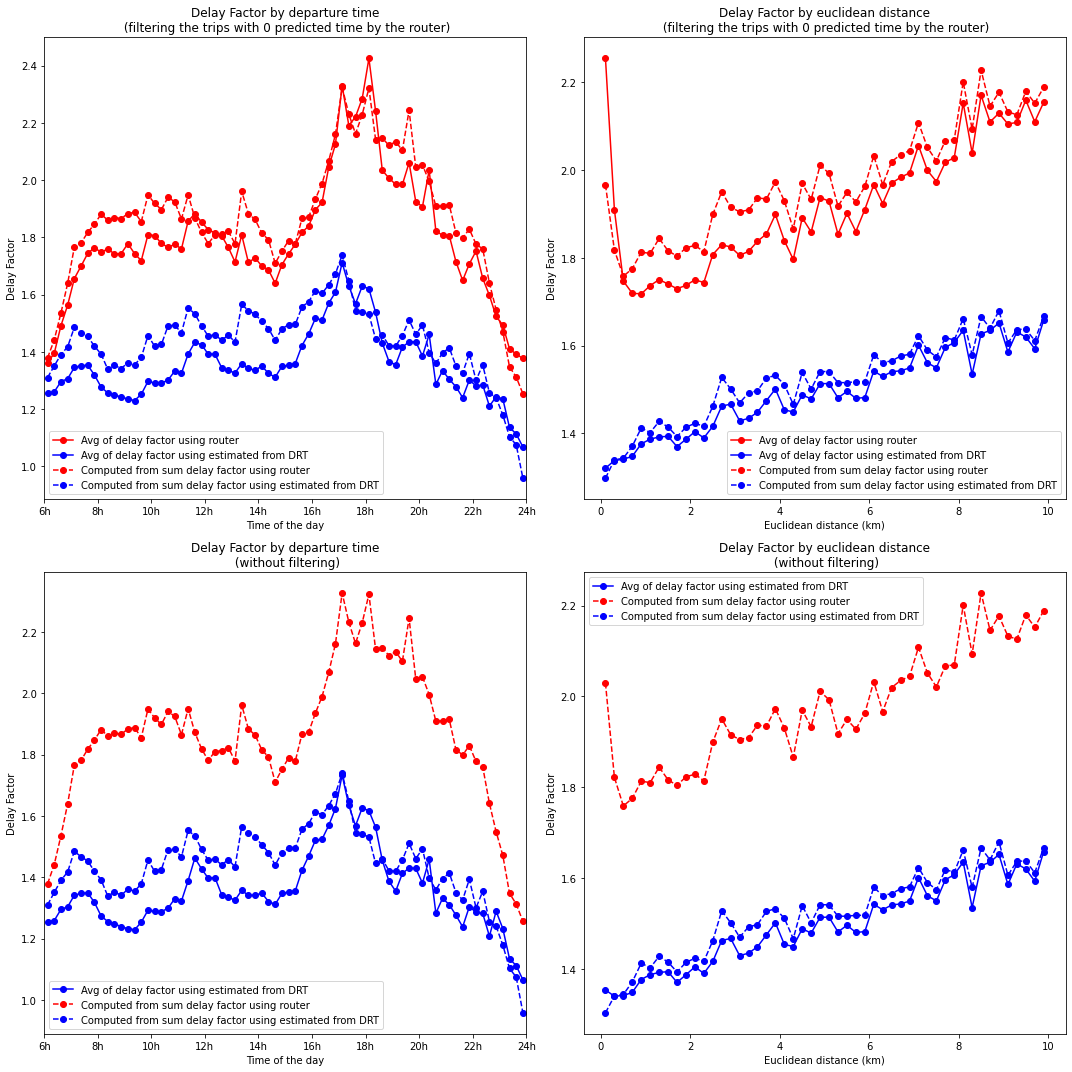

In [17]:
plot_delay_factor(no_rej_4000['drt_trips_stats'][100], start_time, end_time, bin_duration_min,
                 min_distance, max_distance, bin_distance_m)

The estimated travel time by the DRT is usually closer to the travel time -> DF for the estimated from DRT is smaller

In [23]:
def plot_waiting_time(it_drt_trip_stats, start_time, end_time, bin_duration_min, min_distance, max_distance, bin_distance_m):
    filtered_without_router_zeros = it_drt_trip_stats[it_drt_trip_stats.routerUnsharedTime != 0]
    
    waitTime_avg = avg_by_time_bin(filtered_without_router_zeros, 'waitTime', start_time=start_time, 
                                     end_time=end_time, bin_duration_min=bin_duration_min)
    
    plt.figure(figsize=(15,15))
    
    plt.subplot(2,2,1)
    xticks = [z*3600 for z in range(start_time, end_time+1, 2)]
    xticks_labels = [str(z) + 'h' for z in range(start_time, end_time+1, 2)]
    
    plt.plot(waitTime_avg.index.values, waitTime_avg.values/60, 'o-', label='Avg of wait time')
    plt.xlim(start_time*3600,end_time*3600)
    plt.xticks(xticks, xticks_labels)
    plt.title('Wait time by departure time\n (filtering the trips with 0 predicted time by the router)')
    plt.ylabel('Wait time (min)')
    plt.xlabel('Time of the day')
    
    plt.subplot(2,2,3)
    waitTime_avg = avg_by_time_bin(it_drt_trip_stats, 'waitTime', start_time=start_time, 
                                     end_time=end_time, bin_duration_min=bin_duration_min)
    plt.plot(waitTime_avg.index.values, waitTime_avg.values/60, 'o-', label='Avg of wait time')
    plt.xlim(start_time*3600,end_time*3600)
    plt.xticks(xticks, xticks_labels)
    plt.title('Wait time by departure time\n (without filtering)')
    plt.ylabel('Wait time (min)')
    plt.xlabel('Euclidean distance (km)')
    
    plt.subplot(2,2,2)
    waitTime_avg = avg_by_euclidean_distance_bin(filtered_without_router_zeros, 'waitTime', min_distance=min_distance, 
                                     max_distance=max_distance, bin_distance_m=bin_distance_m)
    plt.plot(np.array(waitTime_avg.index.values) / 1000, waitTime_avg.values/60, 'o-', label='Avg of wait time')
    plt.title('Wait time by euclidean distance\n (filtering the trips with 0 predicted time by the router)')
    plt.xlabel('Euclidean distance (km)')
    plt.xlabel('Time of the day')
    plt.subplot(2,2,4)
    waitTime_avg = avg_by_euclidean_distance_bin(it_drt_trip_stats, 'waitTime', min_distance=min_distance, 
                                     max_distance=max_distance, bin_distance_m=bin_distance_m)
    plt.plot(np.array(waitTime_avg.index.values) / 1000, waitTime_avg.values/60, 'o-', label='Avg of wait time')
    plt.title('Wait time by euclidean distance\n (without filtering)')
    plt.ylabel('Wait time (min)')
    plt.xlabel('Euclidean distance (km)')
    
    
    plt.show()
    

In [24]:
np.sqrt((no_rej_4000['drt_trips_stats'][100].startX -no_rej_4000['drt_trips_stats'][100].endX)**2 + (no_rej_4000['drt_trips_stats'][100].startY -no_rej_4000['drt_trips_stats'][100].endY)**2).describe()

count    218240.000000
mean       1734.470370
std        2091.906524
min           5.460794
25%         385.251930
50%         871.133458
75%        2275.178735
max       19963.194883
dtype: float64

We see that 75% of the drt trips are of less than 2.3 km

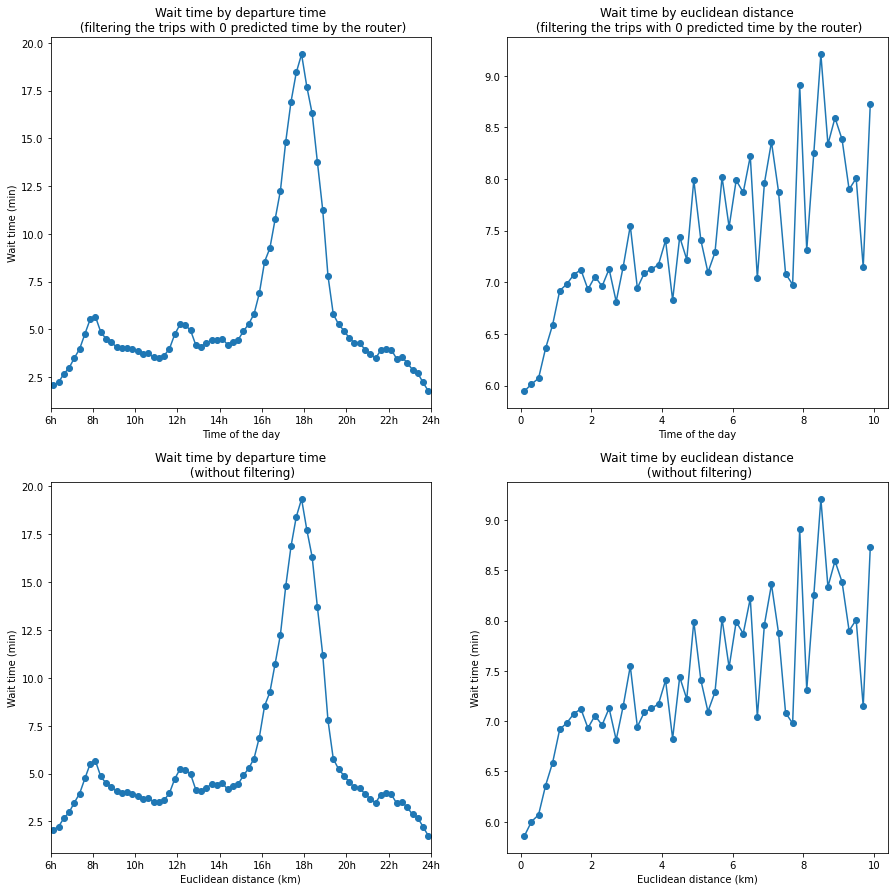

In [25]:
plot_waiting_time(no_rej_4000['drt_trips_stats'][100], start_time, end_time, bin_duration_min,
                 min_distance, max_distance, bin_distance_m)

# Difference between router and estimated

In [26]:
def plot_difference_estimated_router(it_drt_trip_stats):
    filtered_without_router_zeros = it_drt_trip_stats[it_drt_trip_stats.routerUnsharedTime != 0]
    abs_difference = np.abs(filtered_without_router_zeros['estimatedUnsharedTime'] - filtered_without_router_zeros['routerUnsharedTime'])
    abs_difference_min = abs_difference / 60 #absolute difference in minutes
    rel_difference = abs_difference / filtered_without_router_zeros['estimatedUnsharedTime']
    print('Description of abs difference in minutes')
    display(abs_difference_min.describe(percentiles=[0.25,0.5,0.75,0.9,0.95,0.99,0.999]).to_frame().transpose())
    print('Description of relative difference')
    display(rel_difference.describe(percentiles=[0.25,0.5,0.75,0.9,0.95,0.99,0.999]).to_frame().transpose())
    plt.figure(figsize=(15,20))
    plt.subplot(2,2,1)
    plt.hist(abs_difference_min, bins=100, range=(0,15), density=True)
    plt.title('Absolute difference')
    plt.xlabel('difference (min)')
    plt.subplot(2,2,2)
    plt.hist(rel_difference, bins=100, range=(0,1), density=True)
    plt.title('Relative difference')
    plt.subplot(2,2,3)
    plt.boxplot(abs_difference_min, positions=[1])
    plt.ylim(-1,15)
    ax2 = plt.gca().twinx()
    ax2.boxplot(abs_difference_min, positions=[2])
    plt.xticks([1,2],['Zoomed','Non zoomed'])
    plt.subplot(2,2,4)
    plt.boxplot(rel_difference, positions=[1])
    plt.ylim(-0.1,1)
    ax2 = plt.gca().twinx()
    ax2.boxplot(rel_difference, positions=[2])
    plt.xticks([1,2],['Zoomed','Non zoomed'])
    plt.tight_layout()
    plt.show()

In [27]:
no_rej_4000['drt_trips_stats'][100].iloc[np.abs(no_rej_4000['drt_trips_stats'][100]['estimatedUnsharedTime'] - no_rej_4000['drt_trips_stats'][100]['routerUnsharedTime']).argmax()]

personId                   2.017400e+14
startTime                  6.065400e+04
totalTravelTime            1.305400e+04
routerUnsharedTime         1.297058e+04
estimatedUnsharedTime      1.020327e+03
delayFactor                1.006432e+00
waitTime                   1.990000e+02
startX                     2.693723e+06
startY                     1.248622e+06
endX                       2.690963e+06
endY                       1.251315e+06
delayFactorEstimatedDRT    1.279393e+01
Name: 10343, dtype: float64

Description of abs difference in minutes


,count,mean,std,min,25%,50%,75%,90%,95%,99%,99.9%,max
0,215986.0,1.955866,4.494985,0.000027,0.271958,0.511535,1.307748,4.98808,9.660681,22.040813,42.677229,199.170861


Description of relative difference


,count,mean,std,min,25%,50%,75%,90%,95%,99%,99.9%,max
0,215986.0,0.216554,0.31205,0.000002,0.079062,0.157495,0.29277,0.467742,0.587206,0.807082,2.195529,74.569784


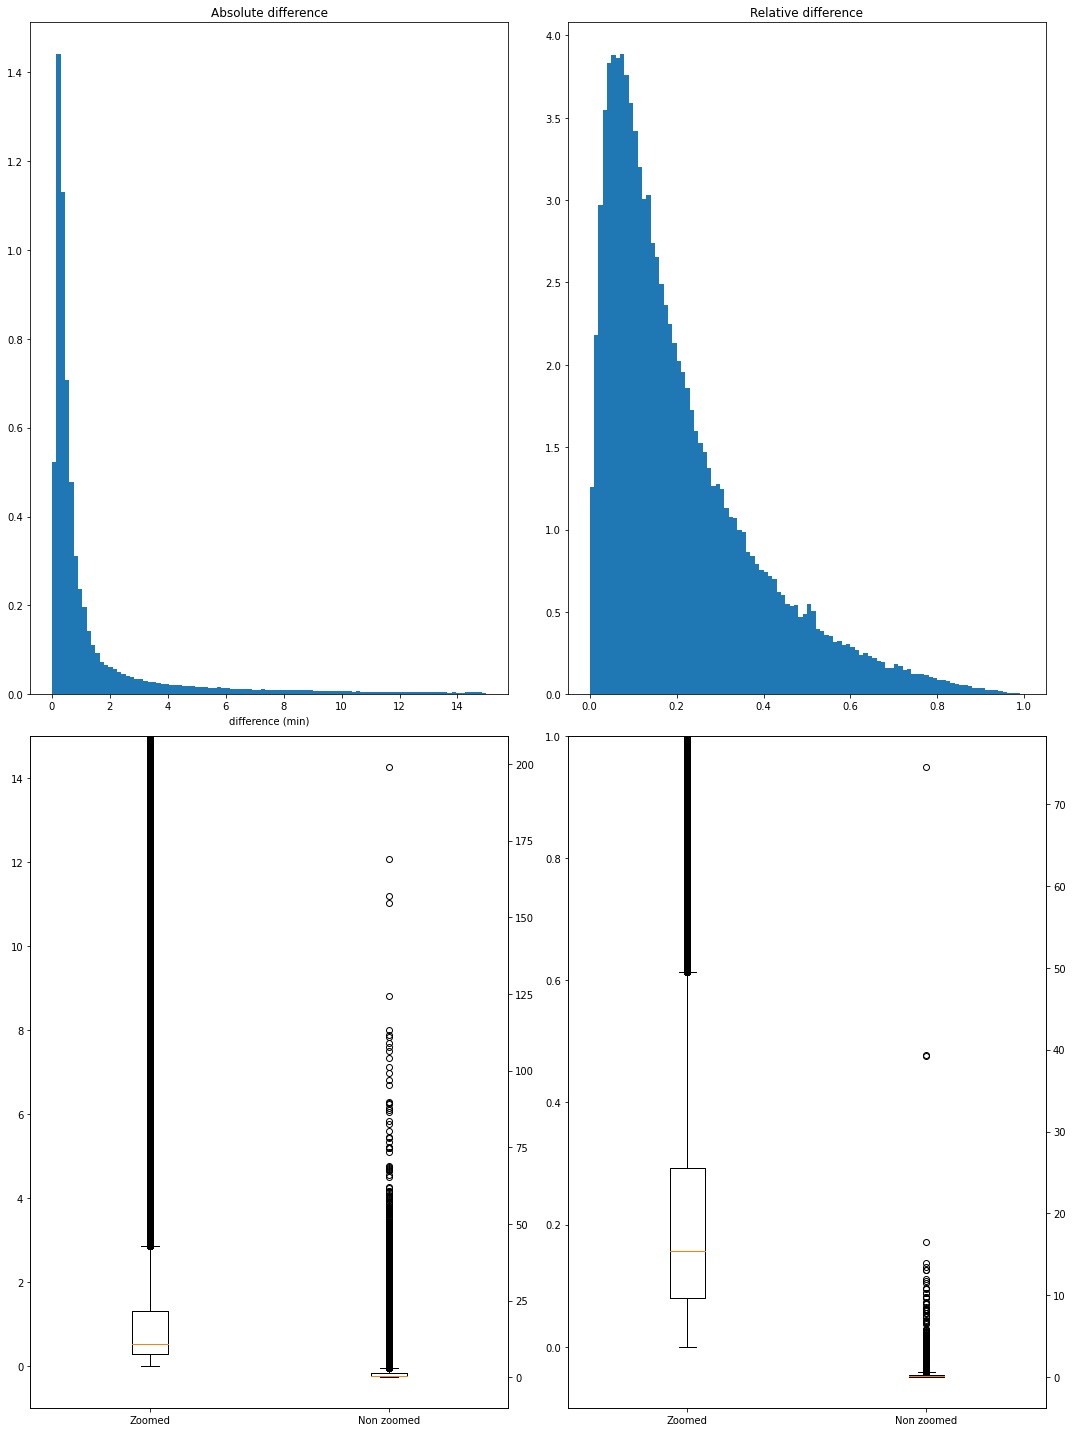

In [28]:
plot_difference_estimated_router(no_rej_4000['drt_trips_stats'][100])

# Convergence of wait time and delay factor

In [29]:
def collect_timeData(averages):
    waitTimes = []
    delayFactors = []
    for df in averages:
        df = df.set_index('stat')
        waitTimes.append(df.loc['waitTime']['avg'])
        delayFactors.append(df.loc['delayFactor']['avg'])
    return np.array(waitTimes), np.array(delayFactors)

In [30]:
def plot_convergence(output_dict):
    waitTimes_global, delayFactors_global = collect_timeData(output_dict['global_avg'])
    waitTimes_successive, delayFactors_successive = collect_timeData(output_dict['global_successive_avg'])
    waitTimes_moving, delayFactors_moving = collect_timeData(output_dict['global_moving_avg'])
    plt.figure(figsize=(15,15))
    plt.subplot(2,1,1)
    plt.plot(waitTimes_global / 60, label='global')
    plt.plot(waitTimes_successive / 60, label='successive')
    plt.plot(waitTimes_moving / 60, label='moving')
    plt.legend()
    plt.title('Convergence of average waitTime')
    plt.ylabel('waitTime (min)')
    plt.xlabel('Iteration')
    plt.subplot(2,1,2)
    plt.plot(delayFactors_global, label='global')
    plt.plot(delayFactors_successive, label='successive')
    plt.plot(delayFactors_moving, label='moving')
    plt.legend()
    plt.title('Convergence of average delayFactor')
    plt.ylabel('delayFactor')
    plt.xlabel('Iteration')
    plt.show()

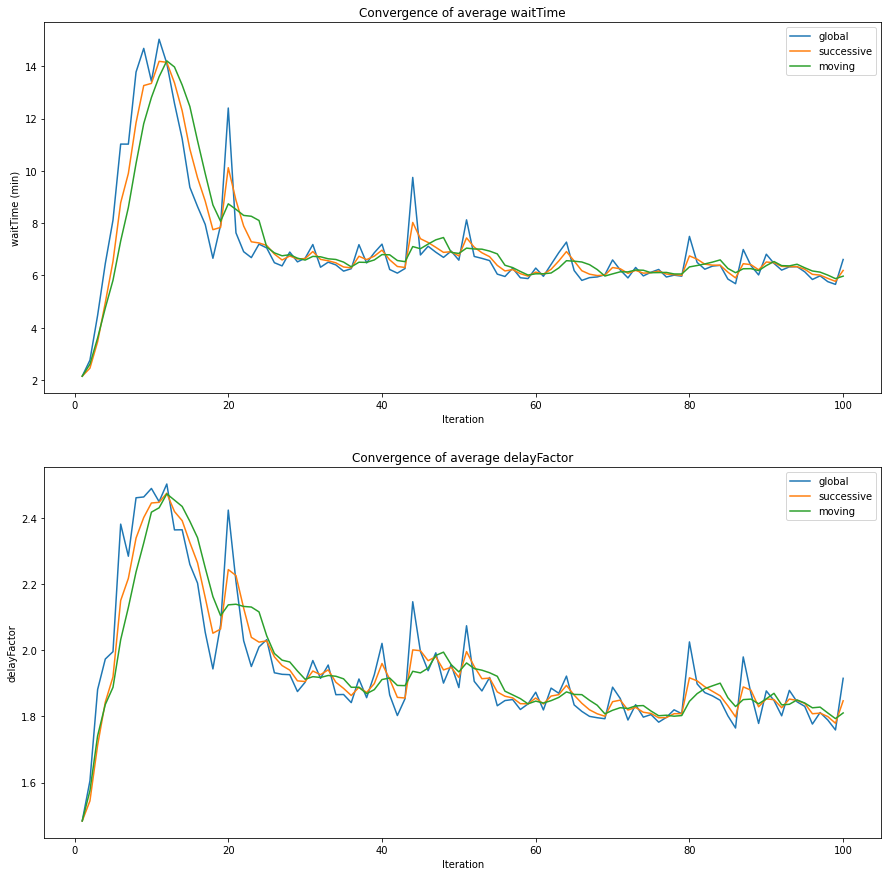

In [31]:
plot_convergence(no_rej_4000)